# Efficient Semantic SLAM Object Detection with YOLOv8

This notebook demonstrates how to perform object detection using YOLOv8 on the TUM RGB-D dataset. It includes steps to download the dataset, run object detection, and visualize results.

In [1]:
# Install dependencies if not already installed
!pip install ultralytics opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
from ultralytics import YOLO
import cv2
import os
import matplotlib.pyplot as plt
import urllib.request
import tarfile
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Download and Prepare TUM RGB-D Dataset

We will download and extract the TUM RGB-D `freiburg1_xyz` sequence used for visual SLAM experiments.

In [3]:
# Download and setup TUM RGB-D dataset
def download_tum_dataset():
    url = "https://cvg.cit.tum.de/rgbd/dataset/freiburg1/rgbd_dataset_freiburg1_xyz.tgz"
    filename = "rgbd_dataset_freiburg1_xyz.tgz"
    if not os.path.exists(filename):
        print(f"Downloading TUM RGB-D dataset from {url}")
        urllib.request.urlretrieve(url, filename)
    if not os.path.exists("rgbd_dataset_freiburg1_xyz"):
        print("Extracting dataset...")
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
    return "rgbd_dataset_freiburg1_xyz/rgb"

In [4]:
# Setup dataset path
rgb_data_path = download_tum_dataset()
image_files = sorted([f for f in os.listdir(rgb_data_path) if f.endswith('.png')])

Extracting dataset...


## Load YOLOv8 Model

We use the lightweight YOLOv8 Nano (`yolov8n.pt`) pretrained on the COCO dataset for fast and efficient object detection.

In [5]:
# Load lightweight YOLOv8 model (pretrained on COCO)
model = YOLO('yolov8n.pt')  # nano model for speed and efficiency

100%|██████████| 6.25M/6.25M [00:00<00:00, 173MB/s]


## Object Detection and Visualization

Define a function to perform object detection and annotate the image with bounding boxes and labels for detected objects above a confidence threshold.

In [6]:
# Detection and visualization function with accuracy filter
def detect_and_draw(image_path, accuracy_threshold=0.65):
    img = cv2.imread(image_path)
    results = model(img, conf=accuracy_threshold, verbose=False)[0]

    for box in results.boxes:
        cls_name = results.names[int(box.cls)]
        confidence = box.conf.item()

        if confidence >= accuracy_threshold:
            label = f"{cls_name}: {confidence:.2f}"
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img

## Sample and Display Detection Results

Randomly select a few RGB frames and visualize the detection results using matplotlib.

In [9]:
# Pick random diverse images
num_samples = 10  # number of images to process
sample_images = random.sample(image_files, num_samples)

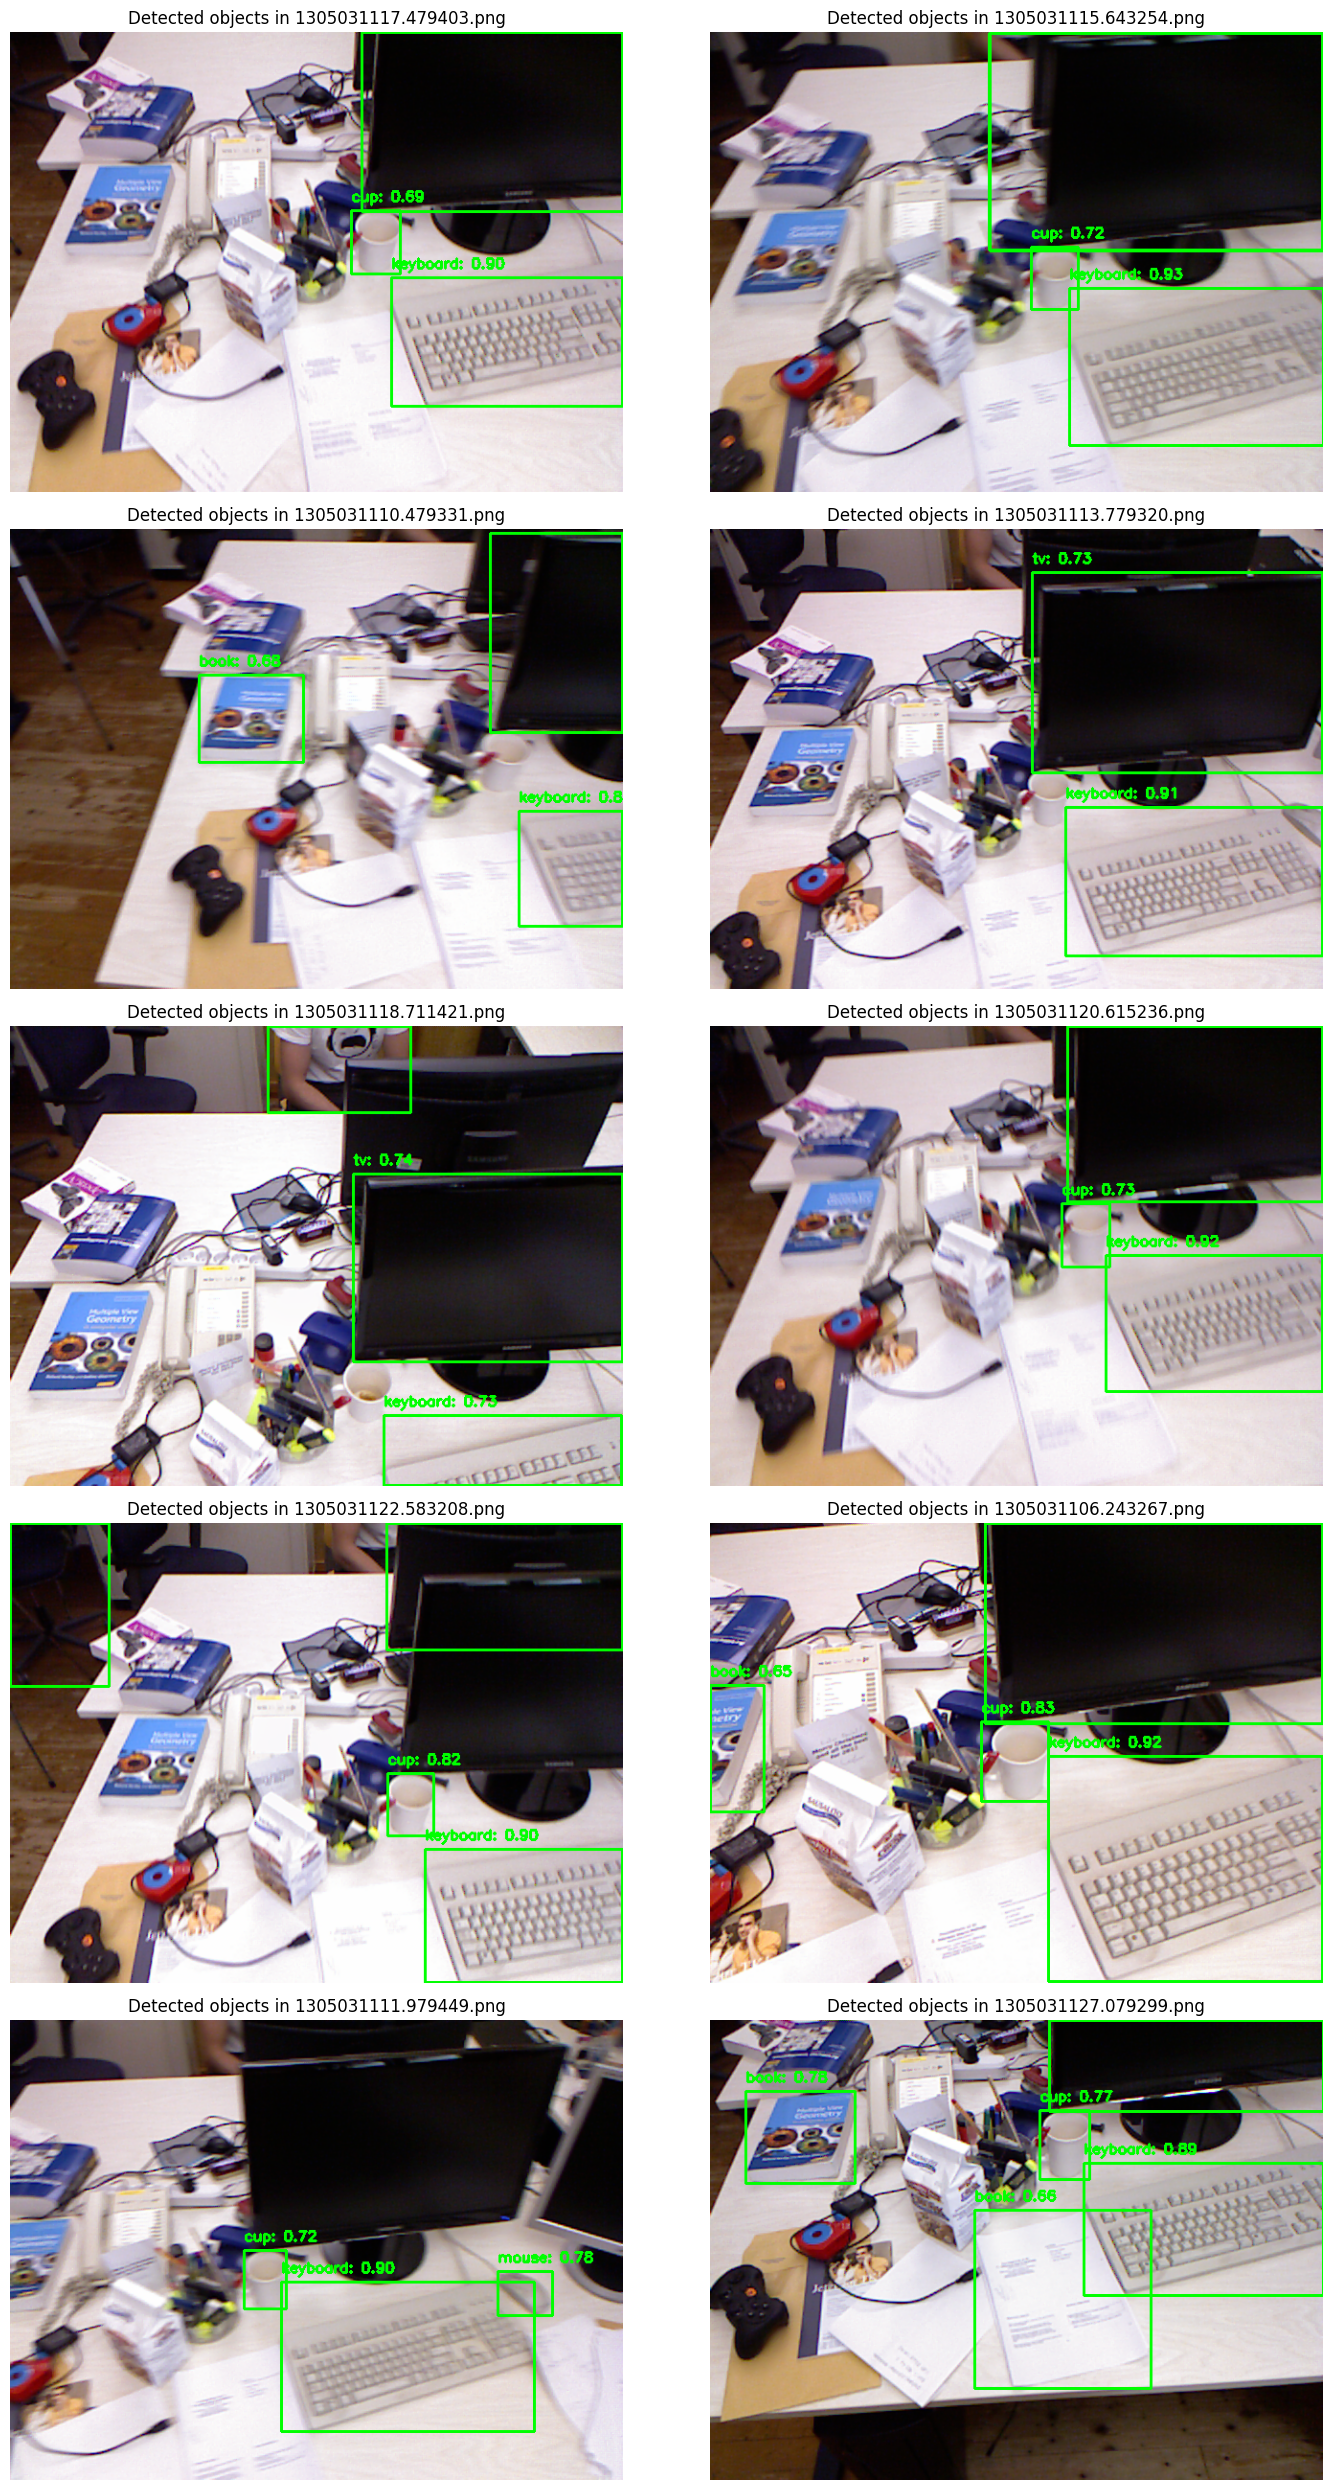

In [10]:
# Display results
cols = 2
rows = (len(sample_images) + 1) // cols

plt.figure(figsize=(15, rows * 5))
for idx, file_name in enumerate(sample_images):
    full_path = os.path.join(rgb_data_path, file_name)
    result_img = detect_and_draw(full_path)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected objects in {file_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()